In [24]:
from client import GameClient
from visualization import GraphTool
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
import json
from pathlib import Path
from qiskit.qasm2 import dumps



In [5]:
from client import GameClient

client = GameClient()

print("Client created")


Client created


In [ ]:
import json
from client import GameClient

with open("session.json", "r") as f:
    session_data = json.load(f)

player_id = session_data.get("player_id")
player_name = session_data.get("name")
api_token = session_data.get("api_token")

print(f"Loaded player info: ID={player_id}, Name={player_name}")




Loaded player info: ID=0315, Name=Ava


In [ ]:

client = GameClient(api_token=api_token)

client.player_id = player_id
client.name = player_name

print("Client initialized with session info.")


Client initialized with session info.


In [8]:

client.print_status()


Player: 0315 (Ava)
Score: 0 | Budget: 40 bell pairs
Active: Yes
Starting node: Tokyo, Japan
Owned: 1 nodes, 0 edges
Claimable edges: 12
  - ['Tokyo, Japan', 'Yokohama, Japan']: threshold=0.90, difficulty=1
  - ['Nagoya, Japan', 'Tokyo, Japan']: threshold=0.90, difficulty=2
  - ['Sendai, Japan', 'Tokyo, Japan']: threshold=0.90, difficulty=2
  ... and 9 more


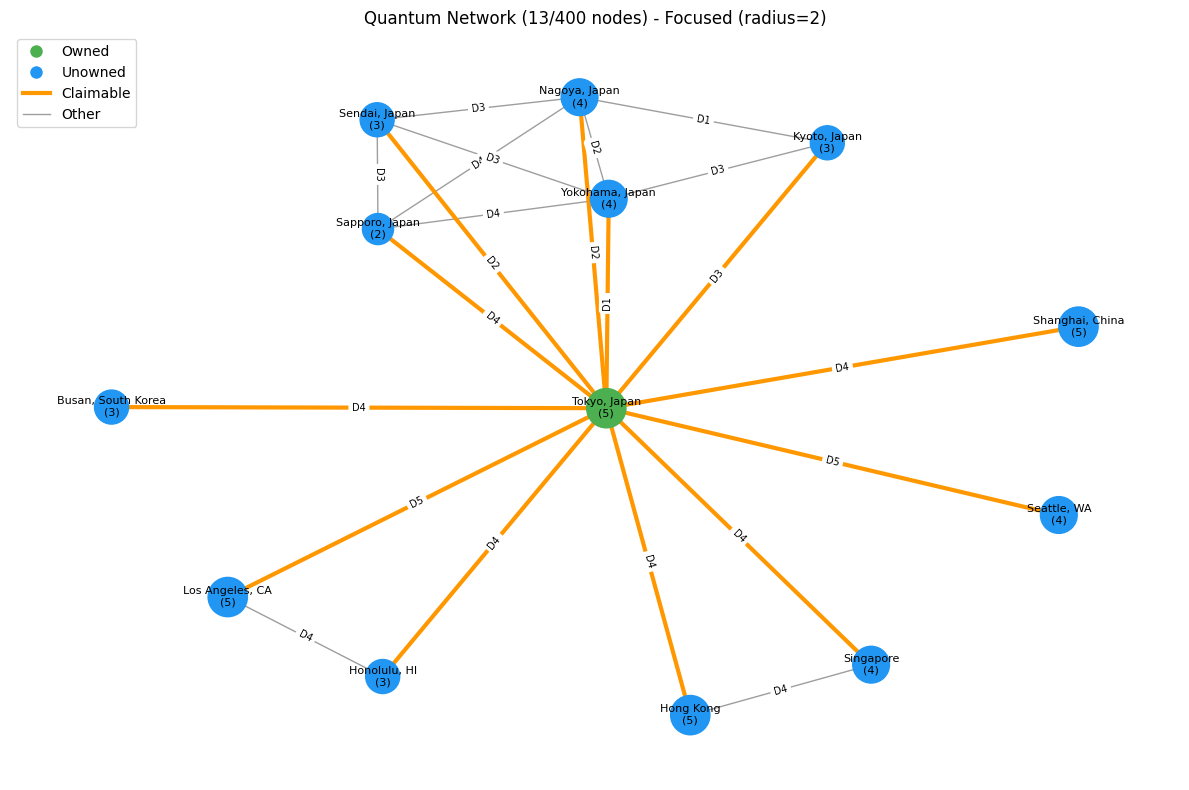

In [9]:
viz = GraphTool(client.get_cached_graph())
owned = set(client.get_status().get('owned_nodes', []))
viz.render(owned)


In [ ]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit

def create_distillation_circuit_4pairs():
    qr = QuantumRegister(8, 'q')
    cr = ClassicalRegister(1, 'c')
    qc = QuantumCircuit(qr, cr)

    # Bit-flip parity check
    qc.cx(qr[3], qr[2])
    qc.cx(qr[4], qr[5])
    qc.cx(qr[2], qr[5])
    qc.cx(qr[5], qr[0])

    # Phase-flip parity check
    qc.h(qr[3])
    qc.h(qr[4])
    qc.h(qr[1])
    qc.h(qr[6])

    qc.cx(qr[3], qr[1])
    qc.cx(qr[4], qr[6])
    qc.cx(qr[1], qr[6])
    qc.cx(qr[6], qr[0])

    qc.h(qr[3])
    qc.h(qr[4])

    qc.measure(qr[0], cr[0])

    return qc


The idea behind this circuit was to start with a basic distillation method using parity checks. One Bell pair was treated as the main pair, and the other pairs were used to check for possible bit-flip and phase-flip errors using CNOT and Hadamard gates. All operations were kept local so that LOCC rules are not violated. This was the simplest and most reasonable starting point before trying more complex strategies.

In [ ]:

claimable = client.get_claimable_edges()

tokyo_edges = [
    e for e in claimable
    if "Tokyo, Japan" in e["edge_id"]
]

tokyo_edges = sorted(tokyo_edges, key=lambda e: (e['difficulty_rating'], e['base_threshold']))

edge = tokyo_edges[0]["edge_id"]
edge_id = (edge[0], edge[1])

# Build circuit
circuit = create_distillation_circuit_4pairs()

# Sanity checks
assert circuit.num_qubits == 8
assert circuit.num_clbits == 1



In [36]:


claimable = client.get_claimable_edges()

print(f"Claimable edges (total = {len(claimable)}):")
claimable_sorted = sorted(claimable, key=lambda e: (e["difficulty_rating"], e["base_threshold"]))

for e in claimable_sorted:
    print(f"{e['edge_id']} | thr={e['base_threshold']:.3f} | D={e['difficulty_rating']}")

print("\n--- Tokyo-connected claimable edges ---")
tokyo_edges = [e for e in claimable if "Tokyo, Japan" in e["edge_id"]]
tokyo_edges_sorted = sorted(tokyo_edges, key=lambda e: (e["difficulty_rating"], e["base_threshold"]))

for e in tokyo_edges_sorted:
    print(f"{e['edge_id']} | thr={e['base_threshold']:.3f} | D={e['difficulty_rating']}")


Claimable edges (total = 12):
['Tokyo, Japan', 'Yokohama, Japan'] | thr=0.900 | D=1
['Nagoya, Japan', 'Tokyo, Japan'] | thr=0.900 | D=2
['Sendai, Japan', 'Tokyo, Japan'] | thr=0.900 | D=2
['Kyoto, Japan', 'Tokyo, Japan'] | thr=0.900 | D=3
['Sapporo, Japan', 'Tokyo, Japan'] | thr=0.920 | D=4
['Busan, South Korea', 'Tokyo, Japan'] | thr=0.920 | D=4
['Hong Kong', 'Tokyo, Japan'] | thr=0.920 | D=4
['Honolulu, HI', 'Tokyo, Japan'] | thr=0.920 | D=4
['Shanghai, China', 'Tokyo, Japan'] | thr=0.920 | D=4
['Singapore', 'Tokyo, Japan'] | thr=0.920 | D=4
['Seattle, WA', 'Tokyo, Japan'] | thr=0.940 | D=5
['Los Angeles, CA', 'Tokyo, Japan'] | thr=0.940 | D=5

--- Tokyo-connected claimable edges ---
['Tokyo, Japan', 'Yokohama, Japan'] | thr=0.900 | D=1
['Nagoya, Japan', 'Tokyo, Japan'] | thr=0.900 | D=2
['Sendai, Japan', 'Tokyo, Japan'] | thr=0.900 | D=2
['Kyoto, Japan', 'Tokyo, Japan'] | thr=0.900 | D=3
['Sapporo, Japan', 'Tokyo, Japan'] | thr=0.920 | D=4
['Busan, South Korea', 'Tokyo, Japan'] | th

In [40]:
import requests

target = tokyo_edges[0]
edge_id = tuple(target["edge_id"])

num_bell_pairs = 4
flag_bit = 0

print(f"Claiming {edge_id} (thr={target['base_threshold']:.3f}, D={target['difficulty_rating']})")

try:
    result = client.claim_edge(edge_id, circuit, flag_bit, num_bell_pairs)
    print("RESULT:", result)
except requests.exceptions.HTTPError as e:
    print("HTTPError:", e)
    if e.response is not None:
        print("STATUS:", e.response.status_code)
        print("RESPONSE TEXT:", e.response.text)
        try:
            print("RESPONSE JSON:", e.response.json())
        except Exception:
            pass


Claiming ('Tokyo, Japan', 'Yokohama, Japan') (thr=0.900, D=1)
HTTPError: 400 Client Error: Bad Request for url: https://demo-entanglement-distillation-qfhvrahfcq-uc.a.run.app/v1/claim_edge
STATUS: 400
RESPONSE TEXT: {"ok":false,"error":{"code":"LOCC_VIOLATION","message":"LOCC violation: gate 'cx' operates on qubits [2, 5], which crosses the Alice/Bob boundary (Alice: 0-3, Bob: 4-7). Multi-qubit gates must act only on qubits within the same side."}}
RESPONSE JSON: {'ok': False, 'error': {'code': 'LOCC_VIOLATION', 'message': "LOCC violation: gate 'cx' operates on qubits [2, 5], which crosses the Alice/Bob boundary (Alice: 0-3, Bob: 4-7). Multi-qubit gates must act only on qubits within the same side."}}


Here I directly tried to claim one edge using the circuit I made. I chose the easiest edge first and kept the Bell pair count fixed to see the output clearly. The error handling was added mainly for debugging, so that any server-side issue or rule violation could be identified quickly. This step was important to understand how the game backend responds to my inputs.

Claiming ('Tokyo, Japan', 'Yokohama, Japan') (thr=0.900, D=1)
{'ok': True, 'data': {'success': False, 'is_valid': False, 'fidelity': 0.8500000000000001, 'success_probability': 0.4999999999999996, 'threshold': 0.9, 'remaining_budget': 40, 'is_active': True, 'score': 0, 'reward_changes': []}}
Success: False
Fidelity: 0.8500 (threshold: 0.9000)
Success probability: 0.5000


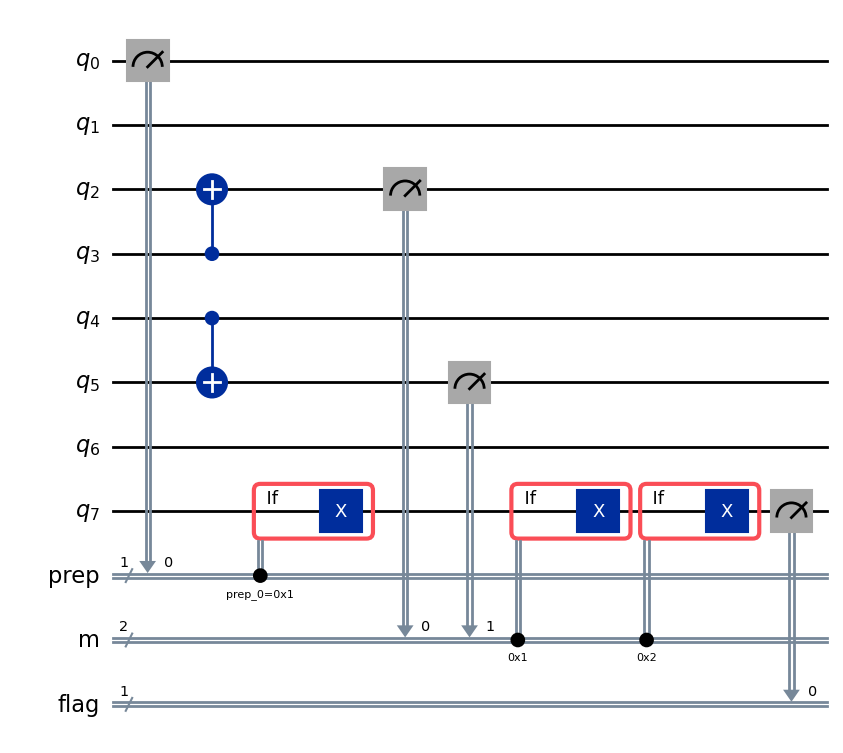

In [81]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit

def create_distillation_circuit_4pairs_LOCC_match():
    """
    LOCC-compliant purification with classical communication:
    Alice qubits: 0-3
    Bob qubits:   4-7

    Use:
      - Data pair:    (q3, q4)
      - Ancilla pair: (q2, q5)
      - Flag helper:  use q7 (Bob) as a flag qubit
      - Helper pair:  (q0, q7) is used to initialize q7 to |0> via measurement + feedforward

    Protocol (BBPSSW-style):
      1) Bilateral CNOT (local only): Alice CX(q3->q2), Bob CX(q4->q5)
      2) Measure ancillas q2 (Alice) and q5 (Bob)
      3) If results mismatch, flip q7 (flag becomes 1)
      4) Measure q7 into final classical flag bit; keep when flag==0
    """
    qr = QuantumRegister(8, 'q')

    # Classical bits:
    prep = ClassicalRegister(1, 'prep')  
    m    = ClassicalRegister(2, 'm')      
    flag = ClassicalRegister(1, 'flag')   

    qc = QuantumCircuit(qr, prep, m, flag)

    # --- Initialize q7 to |0> deterministically using pair (q0,q7)
    qc.measure(qr[0], prep[0])
    with qc.if_test((prep[0], 1)):
        qc.x(qr[7])  

    # --- Bilateral CNOT (local only)
    qc.cx(qr[3], qr[2])   
    qc.cx(qr[4], qr[5])   

    # --- Measure ancillas (this is the CC part)
    qc.measure(qr[2], m[0]) 
    qc.measure(qr[5], m[1])  

  
    with qc.if_test((m, 1)):
        qc.x(qr[7])
    with qc.if_test((m, 2)):
        qc.x(qr[7])

    qc.measure(qr[7], flag[0])

    return qc


claimable = client.get_claimable_edges()
tokyo_edges = [e for e in claimable if "Tokyo, Japan" in e["edge_id"]]
tokyo_edges = sorted(tokyo_edges, key=lambda e: (e["difficulty_rating"], e["base_threshold"]))

target = tokyo_edges[0]
edge_id = tuple(target["edge_id"])

circuit = create_distillation_circuit_4pairs_LOCC_match()
num_bell_pairs = 4

flag_bit = 3

print(f"Claiming {edge_id} (thr={target['base_threshold']:.3f}, D={target['difficulty_rating']})")
result = client.claim_edge(edge_id, circuit, flag_bit, num_bell_pairs)

print(result)
if result.get("ok"):
    data = result["data"]
    print("Success:", data.get("success"))
    print(f"Fidelity: {data.get('fidelity', 0):.4f} (threshold: {data.get('threshold', 0):.4f})")
    print(f"Success probability: {data.get('success_probability', 0):.4f}")
else:
    print("Error:", result.get("error", {}).get("message"))

circuit.draw("mpl")


In [ ]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit

def create_distillation_circuit_6pairs_2round():
    """
    N=6 (12 qubits), Alice 0-5, Bob 6-11.
    Pairs: (0,11)(1,10)(2,9)(3,8)(4,7)(5,6)
    Data pair: (5,6)
    Round1 ancilla: (4,7)
    Round2 ancilla: (3,8)
    Single flag: q11 (Bob local) reset to 0; flip on any mismatch; measure to c[0]
    """
    qr = QuantumRegister(12, "q")
    cr = ClassicalRegister(5, "c")  
    qc = QuantumCircuit(qr, cr)

    qc.reset(qr[11])  

    # Round 1: data (q5,q6) ancilla (q4,q7)
    qc.cx(qr[5], qr[4])    
    qc.cx(qr[6], qr[7])     
    qc.measure(qr[4], cr[1])
    qc.measure(qr[7], cr[2])
    with qc.if_test((cr[1], 1)):
        with qc.if_test((cr[2], 0)):
            qc.x(qr[11])
    with qc.if_test((cr[1], 0)):
        with qc.if_test((cr[2], 1)):
            qc.x(qr[11])

    # Round 2: data (q5,q6) ancilla (q3,q8)
    qc.cx(qr[5], qr[3])     
    qc.cx(qr[6], qr[8])     
    qc.measure(qr[3], cr[3])
    qc.measure(qr[8], cr[4])
    with qc.if_test((cr[3], 1)):
        with qc.if_test((cr[4], 0)):
            qc.x(qr[11])
    with qc.if_test((cr[3], 0)):
        with qc.if_test((cr[4], 1)):
            qc.x(qr[11])

    qc.measure(qr[11], cr[0])
    return qc



claimable = client.get_claimable_edges()
tokyo_edges = [e for e in claimable if "Tokyo, Japan" in e["edge_id"]]
tokyo_edges = sorted(tokyo_edges, key=lambda e: (e["difficulty_rating"], e["base_threshold"]))

d4_tokyo = [e for e in tokyo_edges if e["difficulty_rating"] == 4]


target = None
for e in d4_tokyo:
    if "Shanghai, China" in e["edge_id"]:
        target = e
        break
if target is None and d4_tokyo:
    target = d4_tokyo[0]

if target is None:
    print("No D4 Tokyo-connected edges are claimable right now.")
else:
    edge_id = tuple(target["edge_id"])
    circuit = create_distillation_circuit_6pairs_2round()
    num_bell_pairs = 6
    flag_bit = 0

    print(f"Claiming {edge_id} (thr={target['base_threshold']:.3f}, D={target['difficulty_rating']})")
    result = client.claim_edge(edge_id, circuit, flag_bit, num_bell_pairs)

    print(result)
    if result.get("ok"):
        data = result["data"]
        print("Success:", data.get("success"))
        print(f"Fidelity: {data.get('fidelity', 0):.4f} (threshold: {data.get('threshold', 0):.4f})")
        print(f"Success probability: {data.get('success_probability', 0):.4f}")
    else:
        print("Error:", result.get("error", {}).get("message"))


Claiming ('Shanghai, China', 'Tokyo, Japan') (thr=0.920, D=4)
{'ok': True, 'data': {'success': False, 'is_valid': False, 'fidelity': 0.5425919999999994, 'success_probability': 0.4999999999999998, 'threshold': 0.92, 'remaining_budget': 40, 'is_active': True, 'score': 0, 'reward_changes': []}}
Success: False
Fidelity: 0.5426 (threshold: 0.9200)
Success probability: 0.5000


In [ ]:
import requests

claimable = client.get_claimable_edges()
tokyo_edges = [e for e in claimable if "Tokyo, Japan" in e["edge_id"]]

kyoto_target = None
for e in tokyo_edges:
    if "Kyoto, Japan" in e["edge_id"]:
        kyoto_target = e
        break

if kyoto_target is None:
    print("Kyoto edge is not in claimable Tokyo edges right now.")
else:
    edge_id = tuple(kyoto_target["edge_id"])
    print("Target edge:", edge_id, "| D=", kyoto_target["difficulty_rating"], "| thr=", kyoto_target["base_threshold"])


Target edge: ('Kyoto, Japan', 'Tokyo, Japan') | D= 3 | thr= 0.9


In [ ]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit

def create_distillation_circuit_6pairs_dejmps_2round():
    """
    LOCC compliant (no cross-boundary CX).
    N=6 => 12 qubits
      Alice: 0-5
      Bob:   6-11
    Pairs: (0,11)(1,10)(2,9)(3,8)(4,7)(5,6)
    Data pair: (5,6)
    Round1 ancilla: (4,7)
    Round2 ancilla: (3,8)

    DEJMPS twist: local phase rotations before/after bilateral CNOT
    Post-select: ancilla measurement parity must "match" each round.
    One single flag bit is produced at the end.
    """

    qr = QuantumRegister(12, "q")
    # Classical bits: a1,b1,a2,b2 plus final flag
    cr = ClassicalRegister(5, "c") 
    qc = QuantumCircuit(qr, cr)

    try:
        qc.reset(qr[11])
    except Exception:
        pass

  
    def flip_flag_if_mismatch(a_bit, b_bit):
        with qc.if_test((a_bit, 1)):
            with qc.if_test((b_bit, 0)):
                qc.x(qr[11])
        with qc.if_test((a_bit, 0)):
            with qc.if_test((b_bit, 1)):
                qc.x(qr[11])

    

    # DEJMPS local rotations 
    qc.sdg(qr[5]); qc.sdg(qr[4])
    qc.s(qr[6]);   qc.s(qr[7])

    qc.cx(qr[5], qr[4])   
    qc.cx(qr[6], qr[7])   

    qc.s(qr[5])
    qc.sdg(qr[6])

    qc.measure(qr[4], cr[1]) 
    qc.measure(qr[7], cr[2]) 

    flip_flag_if_mismatch(cr[1], cr[2])


    qc.sdg(qr[5]); qc.sdg(qr[3])
    qc.s(qr[6]);   qc.s(qr[8])

    qc.cx(qr[5], qr[3]) 
    qc.cx(qr[6], qr[8])  

    qc.s(qr[5])
    qc.sdg(qr[6])

    qc.measure(qr[3], cr[3])  
    qc.measure(qr[8], cr[4]) 

    flip_flag_if_mismatch(cr[3], cr[4])

    qc.measure(qr[11], cr[0])

    return qc


claimable = client.get_claimable_edges()
tokyo_edges = [e for e in claimable if "Tokyo, Japan" in e["edge_id"]]

kyoto_target = None
for e in tokyo_edges:
    if "Kyoto, Japan" in e["edge_id"]:
        kyoto_target = e
        break

if kyoto_target is None:
    print("Kyoto edge not claimable right now.")
else:
    edge_id = tuple(kyoto_target["edge_id"])
    circuit = create_distillation_circuit_6pairs_dejmps_2round()

    num_bell_pairs = 6
    flag_bit = 0

    # sanity checks
    assert circuit.num_qubits == 2 * num_bell_pairs
    assert 0 <= flag_bit < circuit.num_clbits

    print(f"Claiming {edge_id} (thr={kyoto_target['base_threshold']:.3f}, D={kyoto_target['difficulty_rating']})")
    result = client.claim_edge(edge_id, circuit, flag_bit, num_bell_pairs)

    print(result)
    if result.get("ok"):
        data = result["data"]
        print("Success:", data.get("success"))
        print(f"Fidelity: {data.get('fidelity', 0):.4f} (threshold: {data.get('threshold', 0):.4f})")
        print(f"Success probability: {data.get('success_probability', 0):.4f}")
    else:
        print("Error:", result.get("error", {}).get("message"))


Claiming ('Kyoto, Japan', 'Tokyo, Japan') (thr=0.900, D=3)
{'ok': True, 'data': {'success': False, 'is_valid': False, 'fidelity': 0.4687499999999999, 'success_probability': 0.4999999999999998, 'threshold': 0.9, 'remaining_budget': 40, 'is_active': True, 'score': 0, 'reward_changes': []}}
Success: False
Fidelity: 0.4687 (threshold: 0.9000)
Success probability: 0.5000


This circuit was an attempt to make the distillation process stronger by using more Bell pairs and running it in two rounds. Extra pairs were used to check for errors step by step, and measurements were used to decide whether the result should be kept or discarded. All operations were done locally so the LOCC condition is respected. The idea was to see if a more detailed distillation process could finally cross the fidelity threshold.

In [ ]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit

def create_distillation_circuit_8pairs_minimal():
    """
    N=8 Bell pairs => 16 qubits
    Alice: 0-7
    Bob:   8-15
    No cross-boundary gates.
    One final flag bit only.
    """
    qr = QuantumRegister(16, 'q')
    cr = ClassicalRegister(1, 'c')
    qc = QuantumCircuit(qr, cr)


  
    qc.cx(qr[7], qr[6]) 
    qc.cx(qr[8], qr[9]) 

    qc.measure(qr[9], cr[0])

    return qc


In [61]:
claimable = client.get_claimable_edges()
tokyo_edges = [e for e in claimable if "Tokyo, Japan" in e["edge_id"]]

target = None
for e in tokyo_edges:
    if "Yokohama, Japan" in e["edge_id"]:
        target = e
        break

edge_id = tuple(target["edge_id"])

circuit = create_distillation_circuit_8pairs_minimal()
num_bell_pairs = 8
flag_bit = 0

print(f"Claiming {edge_id} with {num_bell_pairs} Bell pairs...")
result = client.claim_edge(edge_id, circuit, flag_bit, num_bell_pairs)

print(result)
if result.get("ok"):
    data = result["data"]
    print("Success:", data.get("success"))
    print("Fidelity:", data.get("fidelity"))
    print("Threshold:", data.get("threshold"))


Claiming ('Tokyo, Japan', 'Yokohama, Japan') with 8 Bell pairs...
{'ok': True, 'data': {'success': False, 'is_valid': False, 'fidelity': 0.8558850726552181, 'success_probability': 0.4999999999999994, 'threshold': 0.9, 'remaining_budget': 40, 'is_active': True, 'score': 0, 'reward_changes': []}}
Success: False
Fidelity: 0.8558850726552181
Threshold: 0.9


In [ ]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit

def yokohama_circuit_4pairs_twirled():
    qr = QuantumRegister(8, "q")
    cr = ClassicalRegister(1, "c")
    qc = QuantumCircuit(qr, cr)

    qc.z(qr[3]); qc.z(qr[4])
    qc.x(qr[3]); qc.x(qr[4])

    # Bilateral CNOT (local)
    qc.cx(qr[3], qr[2])
    qc.cx(qr[4], qr[5])

    qc.measure(qr[5], cr[0])
    return qc


In [70]:
claimable = client.get_claimable_edges()
tokyo_edges = [e for e in claimable if "Tokyo, Japan" in e["edge_id"]]
target = next(e for e in tokyo_edges if "Yokohama, Japan" in e["edge_id"])
edge_id = tuple(target["edge_id"])

circuit = yokohama_circuit_4pairs_twirled()
flag_bit=0
num_bell_pairs=4
result = client.claim_edge(edge_id, circuit, flag_bit=4, num_bell_pairs=4)  # flag is 5th classical reg => index 4
print(result)


{'ok': True, 'data': {'success': False, 'is_valid': False, 'fidelity': 0.8500000000000001, 'success_probability': 0.9999999999999992, 'threshold': 0.9, 'remaining_budget': 40, 'is_active': True, 'score': 0, 'reward_changes': []}}


In [ ]:
from qiskit import QuantumCircuit

def twirled_locc_circuit_N4():

    qc = QuantumCircuit(8, 1)

    qc.z(3); qc.z(4)
    qc.x(3); qc.x(4)

    # Local CNOTs
    qc.cx(3, 2)   
    qc.cx(4, 5) 

    qc.measure(5, 0)
    return qc

claimable = client.get_claimable_edges()
tokyo_edges = [e for e in claimable if "Tokyo, Japan" in e["edge_id"]]
tokyo_edges = sorted(tokyo_edges, key=lambda e: (e["difficulty_rating"], e["base_threshold"]))

qc4 = twirled_locc_circuit_N4()
num_bell_pairs = 4
flag_bit = 0

print(f"Scanning {len(tokyo_edges)} Tokyo-connected edges with N=4...\n")

results = []
for e in tokyo_edges:
    edge_id = tuple(e["edge_id"])
    try:
        res = client.claim_edge(edge_id, qc4, flag_bit, num_bell_pairs)
        if res.get("ok"):
            d = res["data"]
            results.append((edge_id, e["difficulty_rating"], d["fidelity"], d["threshold"], d["success_probability"], d["success"]))
            print(f"{edge_id} | D={e['difficulty_rating']} | F={d['fidelity']:.4f} | thr={d['threshold']:.4f} | p={d['success_probability']:.4f} | success={d['success']}")
        else:
            print(f"{edge_id} | D={e['difficulty_rating']} | ERROR: {res.get('error', {}).get('message')}")
    except Exception as ex:
        print(f"{edge_id} | D={e['difficulty_rating']} | EXCEPTION: {ex}")

#show best candidates (closest to threshold)
if results:
    print("\nTop edges by (F - threshold):")
    results_sorted = sorted(results, key=lambda x: (x[2] - x[3]), reverse=True)
    for row in results_sorted[:5]:
        edge_id, D, F, thr, p, success = row
        print(f"{edge_id} | D={D} | F-thr={(F-thr):+.4f} | F={F:.4f} | thr={thr:.4f} | p={p:.4f}")


Scanning 12 Tokyo-connected edges with N=4...

('Tokyo, Japan', 'Yokohama, Japan') | D=1 | F=0.8500 | thr=0.9000 | p=0.5000 | success=False
('Nagoya, Japan', 'Tokyo, Japan') | D=2 | F=0.6800 | thr=0.9000 | p=0.5000 | success=False
('Sendai, Japan', 'Tokyo, Japan') | D=2 | F=0.6800 | thr=0.9000 | p=0.5000 | success=False
('Kyoto, Japan', 'Tokyo, Japan') | D=3 | F=0.7500 | thr=0.9000 | p=0.5000 | success=False
('Sapporo, Japan', 'Tokyo, Japan') | D=4 | F=0.5968 | thr=0.9200 | p=0.5000 | success=False
('Busan, South Korea', 'Tokyo, Japan') | D=4 | F=0.5968 | thr=0.9200 | p=0.5000 | success=False
('Hong Kong', 'Tokyo, Japan') | D=4 | F=0.5968 | thr=0.9200 | p=0.5000 | success=False
('Honolulu, HI', 'Tokyo, Japan') | D=4 | F=0.5968 | thr=0.9200 | p=0.5000 | success=False
('Shanghai, China', 'Tokyo, Japan') | D=4 | F=0.5968 | thr=0.9200 | p=0.5000 | success=False
('Singapore', 'Tokyo, Japan') | D=4 | F=0.5968 | thr=0.9200 | p=0.5000 | success=False
('Seattle, WA', 'Tokyo, Japan') | D=5 | F=0

In [ ]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit

def distillation_N6_LOCC():
    qr = QuantumRegister(12, "q")   # 6 Bell pairs
    cr = ClassicalRegister(1, "c")  # post-selection flag
    qc = QuantumCircuit(qr, cr)

    qc.cx(5, 4)
    qc.cx(5, 3)

    qc.cx(6, 7)
    qc.cx(6, 8)

    qc.h(5)
    qc.cx(5, 2)
    qc.cx(5, 1)
    qc.h(5)

    qc.h(6)
    qc.cx(6, 9)
    qc.cx(6, 10)
    qc.h(6)

    qc.measure(10, cr[0])

    return qc


In [74]:
circuit = distillation_N6_LOCC()

num_bell_pairs = 6
flag_bit = 0

edge_id = ("Tokyo, Japan", "Yokohama, Japan")

result = client.claim_edge(
    edge=edge_id,
    circuit=circuit,
    flag_bit=flag_bit,
    num_bell_pairs=num_bell_pairs
)

print(result)

if result.get("ok"):
    d = result["data"]
    print(f"Success: {d['success']}")
    print(f"Fidelity: {d['fidelity']:.4f}  Threshold: {d['threshold']:.4f}")
    print(f"Success probability: {d['success_probability']:.4f}")


{'ok': True, 'data': {'success': False, 'is_valid': False, 'fidelity': 0.8499999999999995, 'success_probability': 0.4999999999999994, 'threshold': 0.9, 'remaining_budget': 40, 'is_active': True, 'score': 0, 'reward_changes': []}}
Success: False
Fidelity: 0.8500  Threshold: 0.9000
Success probability: 0.5000


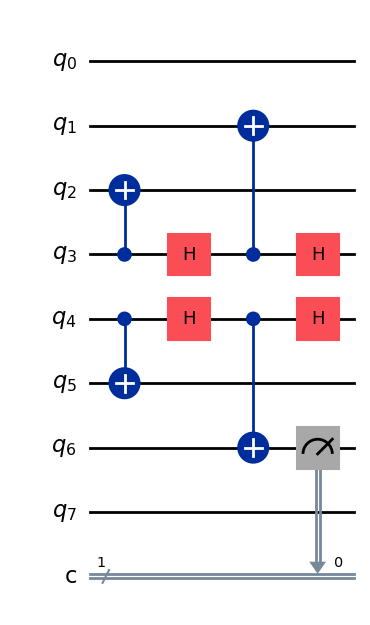

In [ ]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from qiskit.visualization import circuit_drawer

def distillation_N4_LOCC():
    qr = QuantumRegister(8, "q")
    cr = ClassicalRegister(1, "c")
    qc = QuantumCircuit(qr, cr)

    
    qc.cx(3, 2)
    qc.h(3)
    qc.cx(3, 1)
    qc.h(3)


    qc.cx(4, 5)
    qc.h(4)
    qc.cx(4, 6)
    qc.h(4)

    
    qc.measure(6, cr[0])

    return qc

qc4 = distillation_N4_LOCC()


qc4.draw("mpl")


circuit_drawer(qc4, output="mpl", filename="distillation_N4_LOCC.png")
